In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 1000,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1000_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2414764, 828)
(2414764, 1)
validation
(284792, 828)
(284792, 1)
test
(345481, 828)
(345481, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/242 [..............................] - ETA: 4:53 - loss: 0.0309 - STD: 1.2194e-04 - MAE: 0.1487

  5/242 [..............................] - ETA: 3s - loss: 0.0333 - STD: 9.5422e-04 - MAE: 0.1514  

  9/242 [>.............................] - ETA: 3s - loss: 0.0315 - STD: 0.0020 - MAE: 0.1481    

 13/242 [>.............................] - ETA: 3s - loss: 0.0305 - STD: 0.0029 - MAE: 0.1459

 17/242 [=>............................] - ETA: 3s - loss: 0.0297 - STD: 0.0043 - MAE: 0.1445

 21/242 [=>............................] - ETA: 3s - loss: 0.0289 - STD: 0.0059 - MAE: 0.1428

 25/242 [==>...........................] - ETA: 3s - loss: 0.0281 - STD: 0.0085 - MAE: 0.1412

 29/242 [==>...........................] - ETA: 3s - loss: 0.0273 - STD: 0.0127 - MAE: 0.1392

 33/242 [===>..........................] - ETA: 3s - loss: 0.0265 - STD: 0.0183 - MAE: 0.1368

 37/242 [===>..........................] - ETA: 3s - loss: 0.0257 - STD: 0.0254 - MAE: 0.1343

 41/242 [====>.........................] - ETA: 3s - loss: 0.0250 - STD: 0.0322 - MAE: 0.1319

 45/242 [====>.........................] - ETA: 3s - loss: 0.0245 - STD: 0.0378 - MAE: 0.1298

 48/242 [====>.........................] - ETA: 3s - loss: 0.0241 - STD: 0.0410 - MAE: 0.1284

 51/242 [=====>........................] - ETA: 3s - loss: 0.0237 - STD: 0.0435 - MAE: 0.1273

 54/242 [=====>........................] - ETA: 3s - loss: 0.0234 - STD: 0.0458 - MAE: 0.1262

 57/242 [======>.......................] - ETA: 3s - loss: 0.0231 - STD: 0.0481 - MAE: 0.1252

 60/242 [======>.......................] - ETA: 2s - loss: 0.0228 - STD: 0.0506 - MAE: 0.1241

 63/242 [======>.......................] - ETA: 2s - loss: 0.0226 - STD: 0.0530 - MAE: 0.1232

 66/242 [=======>......................] - ETA: 2s - loss: 0.0223 - STD: 0.0552 - MAE: 0.1222

 69/242 [=======>......................] - ETA: 2s - loss: 0.0221 - STD: 0.0571 - MAE: 0.1213

 72/242 [=======>......................] - ETA: 2s - loss: 0.0219 - STD: 0.0587 - MAE: 0.1205

 75/242 [========>.....................] - ETA: 2s - loss: 0.0216 - STD: 0.0602 - MAE: 0.1196

 78/242 [========>.....................] - ETA: 2s - loss: 0.0214 - STD: 0.0617 - MAE: 0.1189

 81/242 [=========>....................] - ETA: 2s - loss: 0.0212 - STD: 0.0632 - MAE: 0.1181

 84/242 [=========>....................] - ETA: 2s - loss: 0.0210 - STD: 0.0646 - MAE: 0.1173

 87/242 [=========>....................] - ETA: 2s - loss: 0.0208 - STD: 0.0660 - MAE: 0.1165

 90/242 [==========>...................] - ETA: 2s - loss: 0.0206 - STD: 0.0673 - MAE: 0.1158

 93/242 [==========>...................] - ETA: 2s - loss: 0.0204 - STD: 0.0686 - MAE: 0.1151

 96/242 [==========>...................] - ETA: 2s - loss: 0.0203 - STD: 0.0699 - MAE: 0.1144

 99/242 [===========>..................] - ETA: 2s - loss: 0.0201 - STD: 0.0711 - MAE: 0.1137

103/242 [===========>..................] - ETA: 2s - loss: 0.0199 - STD: 0.0727 - MAE: 0.1128

106/242 [============>.................] - ETA: 2s - loss: 0.0197 - STD: 0.0738 - MAE: 0.1122

109/242 [============>.................] - ETA: 2s - loss: 0.0195 - STD: 0.0749 - MAE: 0.1116

112/242 [============>.................] - ETA: 2s - loss: 0.0194 - STD: 0.0758 - MAE: 0.1110

115/242 [=============>................] - ETA: 2s - loss: 0.0193 - STD: 0.0768 - MAE: 0.1104

118/242 [=============>................] - ETA: 2s - loss: 0.0191 - STD: 0.0777 - MAE: 0.1099

121/242 [==============>...............] - ETA: 2s - loss: 0.0190 - STD: 0.0786 - MAE: 0.1094

124/242 [==============>...............] - ETA: 2s - loss: 0.0189 - STD: 0.0794 - MAE: 0.1089

127/242 [==============>...............] - ETA: 1s - loss: 0.0187 - STD: 0.0802 - MAE: 0.1084

130/242 [===============>..............] - ETA: 1s - loss: 0.0186 - STD: 0.0810 - MAE: 0.1079

133/242 [===============>..............] - ETA: 1s - loss: 0.0185 - STD: 0.0817 - MAE: 0.1075

136/242 [===============>..............] - ETA: 1s - loss: 0.0184 - STD: 0.0825 - MAE: 0.1070

139/242 [================>.............] - ETA: 1s - loss: 0.0183 - STD: 0.0832 - MAE: 0.1066

142/242 [================>.............] - ETA: 1s - loss: 0.0182 - STD: 0.0839 - MAE: 0.1062

145/242 [================>.............] - ETA: 1s - loss: 0.0181 - STD: 0.0846 - MAE: 0.1058

148/242 [=================>............] - ETA: 1s - loss: 0.0180 - STD: 0.0852 - MAE: 0.1054

151/242 [=================>............] - ETA: 1s - loss: 0.0179 - STD: 0.0859 - MAE: 0.1050

154/242 [==================>...........] - ETA: 1s - loss: 0.0178 - STD: 0.0865 - MAE: 0.1046

157/242 [==================>...........] - ETA: 1s - loss: 0.0177 - STD: 0.0871 - MAE: 0.1042

160/242 [==================>...........] - ETA: 1s - loss: 0.0176 - STD: 0.0877 - MAE: 0.1038

163/242 [===================>..........] - ETA: 1s - loss: 0.0175 - STD: 0.0883 - MAE: 0.1034

166/242 [===================>..........] - ETA: 1s - loss: 0.0174 - STD: 0.0889 - MAE: 0.1030

169/242 [===================>..........] - ETA: 1s - loss: 0.0173 - STD: 0.0895 - MAE: 0.1027

172/242 [====================>.........] - ETA: 1s - loss: 0.0172 - STD: 0.0900 - MAE: 0.1023

175/242 [====================>.........] - ETA: 1s - loss: 0.0171 - STD: 0.0906 - MAE: 0.1019

178/242 [=====================>........] - ETA: 1s - loss: 0.0170 - STD: 0.0911 - MAE: 0.1016

181/242 [=====================>........] - ETA: 1s - loss: 0.0169 - STD: 0.0917 - MAE: 0.1013

184/242 [=====================>........] - ETA: 1s - loss: 0.0169 - STD: 0.0921 - MAE: 0.1011

188/242 [======================>.......] - ETA: 1s - loss: 0.0168 - STD: 0.0928 - MAE: 0.1007

192/242 [======================>.......] - ETA: 1s - loss: 0.0167 - STD: 0.0934 - MAE: 0.1004

196/242 [=======================>......] - ETA: 0s - loss: 0.0166 - STD: 0.0938 - MAE: 0.1001

200/242 [=======================>......] - ETA: 0s - loss: 0.0165 - STD: 0.0943 - MAE: 0.0997

204/242 [========================>.....] - ETA: 0s - loss: 0.0164 - STD: 0.0948 - MAE: 0.0993

208/242 [========================>.....] - ETA: 0s - loss: 0.0163 - STD: 0.0953 - MAE: 0.0990

212/242 [=========================>....] - ETA: 0s - loss: 0.0162 - STD: 0.0958 - MAE: 0.0986

216/242 [=========================>....] - ETA: 0s - loss: 0.0161 - STD: 0.0964 - MAE: 0.0982

220/242 [==========================>...] - ETA: 0s - loss: 0.0161 - STD: 0.0969 - MAE: 0.0979

224/242 [==========================>...] - ETA: 0s - loss: 0.0160 - STD: 0.0975 - MAE: 0.0975

228/242 [===========================>..] - ETA: 0s - loss: 0.0159 - STD: 0.0980 - MAE: 0.0972

232/242 [===========================>..] - ETA: 0s - loss: 0.0158 - STD: 0.0985 - MAE: 0.0969

236/242 [============================>.] - ETA: 0s - loss: 0.0157 - STD: 0.0990 - MAE: 0.0966

240/242 [============================>.] - ETA: 0s - loss: 0.0156 - STD: 0.0995 - MAE: 0.0963

242/242 [==============================] - 7s 23ms/step - loss: 0.0156 - STD: 0.0998 - MAE: 0.0962 - val_loss: 0.0129 - val_STD: 0.0721 - val_MAE: 0.0879


Epoch 2/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0147 - STD: 0.1096 - MAE: 0.0888

  5/242 [..............................] - ETA: 3s - loss: 0.0124 - STD: 0.1251 - MAE: 0.0835 

  9/242 [>.............................] - ETA: 3s - loss: 0.0121 - STD: 0.1240 - MAE: 0.0820

 13/242 [>.............................] - ETA: 3s - loss: 0.0117 - STD: 0.1247 - MAE: 0.0810

 17/242 [=>............................] - ETA: 3s - loss: 0.0116 - STD: 0.1243 - MAE: 0.0804

 21/242 [=>............................] - ETA: 3s - loss: 0.0115 - STD: 0.1251 - MAE: 0.0799

 25/242 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.1254 - MAE: 0.0793

 29/242 [==>...........................] - ETA: 3s - loss: 0.0112 - STD: 0.1259 - MAE: 0.0790

 33/242 [===>..........................] - ETA: 3s - loss: 0.0111 - STD: 0.1263 - MAE: 0.0786

 37/242 [===>..........................] - ETA: 3s - loss: 0.0110 - STD: 0.1267 - MAE: 0.0782

 41/242 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 0.1269 - MAE: 0.0782

 45/242 [====>.........................] - ETA: 3s - loss: 0.0112 - STD: 0.1272 - MAE: 0.0789

 49/242 [=====>........................] - ETA: 2s - loss: 0.0111 - STD: 0.1274 - MAE: 0.0788

 53/242 [=====>........................] - ETA: 2s - loss: 0.0111 - STD: 0.1274 - MAE: 0.0787

 57/242 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 0.1272 - MAE: 0.0787

 61/242 [======>.......................] - ETA: 2s - loss: 0.0111 - STD: 0.1273 - MAE: 0.0786

 65/242 [=======>......................] - ETA: 2s - loss: 0.0111 - STD: 0.1272 - MAE: 0.0785

 69/242 [=======>......................] - ETA: 2s - loss: 0.0110 - STD: 0.1274 - MAE: 0.0783

 73/242 [========>.....................] - ETA: 2s - loss: 0.0110 - STD: 0.1274 - MAE: 0.0782

 77/242 [========>.....................] - ETA: 2s - loss: 0.0109 - STD: 0.1276 - MAE: 0.0781

 81/242 [=========>....................] - ETA: 2s - loss: 0.0109 - STD: 0.1277 - MAE: 0.0779

 85/242 [=========>....................] - ETA: 2s - loss: 0.0109 - STD: 0.1280 - MAE: 0.0778

 89/242 [==========>...................] - ETA: 2s - loss: 0.0108 - STD: 0.1281 - MAE: 0.0777

 93/242 [==========>...................] - ETA: 2s - loss: 0.0109 - STD: 0.1283 - MAE: 0.0778

 97/242 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.1284 - MAE: 0.0777

101/242 [===========>..................] - ETA: 2s - loss: 0.0108 - STD: 0.1284 - MAE: 0.0777

105/242 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.1285 - MAE: 0.0777

109/242 [============>.................] - ETA: 2s - loss: 0.0108 - STD: 0.1285 - MAE: 0.0776

113/242 [=============>................] - ETA: 1s - loss: 0.0108 - STD: 0.1285 - MAE: 0.0776

117/242 [=============>................] - ETA: 1s - loss: 0.0108 - STD: 0.1286 - MAE: 0.0775

121/242 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 0.1286 - MAE: 0.0774

125/242 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 0.1287 - MAE: 0.0773

129/242 [==============>...............] - ETA: 1s - loss: 0.0107 - STD: 0.1287 - MAE: 0.0772

133/242 [===============>..............] - ETA: 1s - loss: 0.0107 - STD: 0.1289 - MAE: 0.0771

137/242 [===============>..............] - ETA: 1s - loss: 0.0107 - STD: 0.1290 - MAE: 0.0771

141/242 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 0.1291 - MAE: 0.0770

145/242 [================>.............] - ETA: 1s - loss: 0.0106 - STD: 0.1292 - MAE: 0.0769

149/242 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 0.1293 - MAE: 0.0768

152/242 [=================>............] - ETA: 1s - loss: 0.0106 - STD: 0.1294 - MAE: 0.0768

156/242 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 0.1295 - MAE: 0.0767

160/242 [==================>...........] - ETA: 1s - loss: 0.0106 - STD: 0.1295 - MAE: 0.0767

164/242 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.1296 - MAE: 0.0769

168/242 [===================>..........] - ETA: 1s - loss: 0.0106 - STD: 0.1297 - MAE: 0.0768

172/242 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 0.1296 - MAE: 0.0768

176/242 [====================>.........] - ETA: 1s - loss: 0.0106 - STD: 0.1297 - MAE: 0.0767

180/242 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 0.1297 - MAE: 0.0767

184/242 [=====================>........] - ETA: 0s - loss: 0.0105 - STD: 0.1297 - MAE: 0.0766

188/242 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.1298 - MAE: 0.0765

192/242 [======================>.......] - ETA: 0s - loss: 0.0105 - STD: 0.1298 - MAE: 0.0765

196/242 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.1299 - MAE: 0.0764

200/242 [=======================>......] - ETA: 0s - loss: 0.0105 - STD: 0.1300 - MAE: 0.0763

204/242 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.1301 - MAE: 0.0763

208/242 [========================>.....] - ETA: 0s - loss: 0.0105 - STD: 0.1302 - MAE: 0.0762

212/242 [=========================>....] - ETA: 0s - loss: 0.0104 - STD: 0.1302 - MAE: 0.0762

216/242 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.1303 - MAE: 0.0763

220/242 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.1304 - MAE: 0.0764

224/242 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.1304 - MAE: 0.0763

228/242 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.1304 - MAE: 0.0763

232/242 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.1304 - MAE: 0.0763

236/242 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.1304 - MAE: 0.0762

240/242 [============================>.] - ETA: 0s - loss: 0.0104 - STD: 0.1304 - MAE: 0.0762

242/242 [==============================] - 4s 17ms/step - loss: 0.0104 - STD: 0.1304 - MAE: 0.0761 - val_loss: 0.0087 - val_STD: 0.0835 - val_MAE: 0.0721


Epoch 3/10000


  1/242 [..............................] - ETA: 9s - loss: 0.0095 - STD: 0.1350 - MAE: 0.0732

  4/242 [..............................] - ETA: 4s - loss: 0.0097 - STD: 0.1332 - MAE: 0.0734

  8/242 [..............................] - ETA: 3s - loss: 0.0097 - STD: 0.1327 - MAE: 0.0734

 12/242 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.1337 - MAE: 0.0735

 16/242 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.1339 - MAE: 0.0735

 20/242 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 0.1338 - MAE: 0.0736

 24/242 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 0.1343 - MAE: 0.0735

 28/242 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.1342 - MAE: 0.0735

 32/242 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.1342 - MAE: 0.0735

 36/242 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.1342 - MAE: 0.0733

 39/242 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.1342 - MAE: 0.0732

 43/242 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.1342 - MAE: 0.0731

 47/242 [====>.........................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0733

 51/242 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.1345 - MAE: 0.0732

 55/242 [=====>........................] - ETA: 2s - loss: 0.0097 - STD: 0.1346 - MAE: 0.0732

 59/242 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.1345 - MAE: 0.0732

 63/242 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.1345 - MAE: 0.0733

 67/242 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.1346 - MAE: 0.0733

 71/242 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

 75/242 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

 79/242 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0733

 83/242 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0734

 87/242 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0733

 91/242 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0733

 95/242 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.1342 - MAE: 0.0733

 99/242 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0733

103/242 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0732

107/242 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

111/242 [============>.................] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0731

115/242 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

119/242 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

123/242 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0732

127/242 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

131/242 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0732

135/242 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0732

139/242 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0732

143/242 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.1343 - MAE: 0.0731

147/242 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.1344 - MAE: 0.0731

151/242 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.1344 - MAE: 0.0730

155/242 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.1345 - MAE: 0.0730

159/242 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.1345 - MAE: 0.0730

163/242 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.1345 - MAE: 0.0730

167/242 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0730

171/242 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0730

175/242 [====================>.........] - ETA: 1s - loss: 0.0097 - STD: 0.1346 - MAE: 0.0730

179/242 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0730

183/242 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0730

187/242 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0729

190/242 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0729

194/242 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0729

198/242 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0728

202/242 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.1347 - MAE: 0.0728

206/242 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.1347 - MAE: 0.0727

210/242 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.1348 - MAE: 0.0728

214/242 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.1348 - MAE: 0.0729

217/242 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.1348 - MAE: 0.0729

221/242 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.1347 - MAE: 0.0729

225/242 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0729

229/242 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0729

233/242 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0728

236/242 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0728

240/242 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 0.1346 - MAE: 0.0728

242/242 [==============================] - 4s 17ms/step - loss: 0.0096 - STD: 0.1346 - MAE: 0.0728 - val_loss: 0.0088 - val_STD: 0.0784 - val_MAE: 0.0726


Epoch 4/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0099 - STD: 0.1293 - MAE: 0.0729

  5/242 [..............................] - ETA: 3s - loss: 0.0095 - STD: 0.1362 - MAE: 0.0721 

  9/242 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 0.1360 - MAE: 0.0713

 13/242 [>.............................] - ETA: 3s - loss: 0.0092 - STD: 0.1360 - MAE: 0.0710

 17/242 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0710

 21/242 [=>............................] - ETA: 3s - loss: 0.0092 - STD: 0.1366 - MAE: 0.0709

 25/242 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 0.1367 - MAE: 0.0708

 29/242 [==>...........................] - ETA: 3s - loss: 0.0091 - STD: 0.1367 - MAE: 0.0708

 33/242 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.1369 - MAE: 0.0708

 37/242 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 0.1370 - MAE: 0.0711

 41/242 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 0.1369 - MAE: 0.0710

 45/242 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 0.1368 - MAE: 0.0711

 49/242 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 0.1368 - MAE: 0.0711

 53/242 [=====>........................] - ETA: 2s - loss: 0.0092 - STD: 0.1367 - MAE: 0.0711

 57/242 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0711

 61/242 [======>.......................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0711

 65/242 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0711

 69/242 [=======>......................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0710

 73/242 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 0.1366 - MAE: 0.0712

 77/242 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0712

 81/242 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

 85/242 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

 89/242 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

 93/242 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

 97/242 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0710

101/242 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0711

105/242 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

109/242 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

113/242 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

117/242 [=============>................] - ETA: 1s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

121/242 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

125/242 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

129/242 [==============>...............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

133/242 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

137/242 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

141/242 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0711

145/242 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

149/242 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

153/242 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

157/242 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

161/242 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

165/242 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

169/242 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.1365 - MAE: 0.0710

173/242 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

177/242 [====================>.........] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

181/242 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

185/242 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

189/242 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0711

193/242 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

197/242 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

201/242 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

205/242 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.1363 - MAE: 0.0710

209/242 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

213/242 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710

217/242 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

221/242 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

225/242 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

228/242 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

232/242 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

236/242 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

240/242 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.1364 - MAE: 0.0709

242/242 [==============================] - 4s 17ms/step - loss: 0.0092 - STD: 0.1364 - MAE: 0.0710 - val_loss: 0.0080 - val_STD: 0.0816 - val_MAE: 0.0687


Epoch 5/10000


  1/242 [..............................] - ETA: 10s - loss: 0.0088 - STD: 0.1339 - MAE: 0.0692

  4/242 [..............................] - ETA: 4s - loss: 0.0092 - STD: 0.1333 - MAE: 0.0705 

  8/242 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.1353 - MAE: 0.0699

 12/242 [>.............................] - ETA: 3s - loss: 0.0089 - STD: 0.1353 - MAE: 0.0697

 16/242 [>.............................] - ETA: 3s - loss: 0.0089 - STD: 0.1356 - MAE: 0.0695

 19/242 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.1354 - MAE: 0.0695

 23/242 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.1360 - MAE: 0.0696

 27/242 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.1363 - MAE: 0.0702

 31/242 [==>...........................] - ETA: 3s - loss: 0.0091 - STD: 0.1361 - MAE: 0.0703

 35/242 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.1364 - MAE: 0.0705

 39/242 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.1361 - MAE: 0.0706

 43/242 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.1362 - MAE: 0.0706

 47/242 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.1360 - MAE: 0.0705

 51/242 [=====>........................] - ETA: 2s - loss: 0.0091 - STD: 0.1360 - MAE: 0.0704

 55/242 [=====>........................] - ETA: 2s - loss: 0.0090 - STD: 0.1361 - MAE: 0.0703

 59/242 [======>.......................] - ETA: 2s - loss: 0.0090 - STD: 0.1363 - MAE: 0.0702

 63/242 [======>.......................] - ETA: 2s - loss: 0.0090 - STD: 0.1363 - MAE: 0.0701

 67/242 [=======>......................] - ETA: 2s - loss: 0.0090 - STD: 0.1366 - MAE: 0.0700

 71/242 [=======>......................] - ETA: 2s - loss: 0.0090 - STD: 0.1367 - MAE: 0.0700

 75/242 [========>.....................] - ETA: 2s - loss: 0.0090 - STD: 0.1367 - MAE: 0.0700

 79/242 [========>.....................] - ETA: 2s - loss: 0.0090 - STD: 0.1367 - MAE: 0.0701

 83/242 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0701

 87/242 [=========>....................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0700

 91/242 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0701

 95/242 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.1369 - MAE: 0.0700

 99/242 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0700

103/242 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0700

106/242 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0700

110/242 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.1368 - MAE: 0.0700

114/242 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.1369 - MAE: 0.0700

118/242 [=============>................] - ETA: 1s - loss: 0.0090 - STD: 0.1369 - MAE: 0.0699

122/242 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.1369 - MAE: 0.0699

126/242 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

129/242 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

133/242 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

137/242 [===============>..............] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

141/242 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0698

145/242 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

149/242 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

153/242 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0698

157/242 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

161/242 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

165/242 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0698

169/242 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

173/242 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0699

177/242 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

181/242 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

185/242 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

189/242 [======================>.......] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

193/242 [======================>.......] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0698

197/242 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0697

200/242 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0697

204/242 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0697

208/242 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0696

212/242 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0696

216/242 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0696

220/242 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.1373 - MAE: 0.0696

223/242 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0696

227/242 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.1373 - MAE: 0.0696

231/242 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.1373 - MAE: 0.0696

235/242 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.1373 - MAE: 0.0695

239/242 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.1373 - MAE: 0.0695

242/242 [==============================] - 4s 18ms/step - loss: 0.0089 - STD: 0.1372 - MAE: 0.0696 - val_loss: 0.0102 - val_STD: 0.0905 - val_MAE: 0.0771


Epoch 6/10000


  1/242 [..............................] - ETA: 10s - loss: 0.0103 - STD: 0.1489 - MAE: 0.0765

  5/242 [..............................] - ETA: 3s - loss: 0.0093 - STD: 0.1379 - MAE: 0.0713 

  9/242 [>.............................] - ETA: 3s - loss: 0.0091 - STD: 0.1378 - MAE: 0.0706

 13/242 [>.............................] - ETA: 3s - loss: 0.0091 - STD: 0.1366 - MAE: 0.0703

 17/242 [=>............................] - ETA: 3s - loss: 0.0090 - STD: 0.1369 - MAE: 0.0702

 21/242 [=>............................] - ETA: 3s - loss: 0.0090 - STD: 0.1366 - MAE: 0.0699

 25/242 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.1367 - MAE: 0.0698

 29/242 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.1366 - MAE: 0.0696

 33/242 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.1369 - MAE: 0.0695

 37/242 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.1369 - MAE: 0.0694

 41/242 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.1372 - MAE: 0.0692

 45/242 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

 49/242 [=====>........................] - ETA: 2s - loss: 0.0088 - STD: 0.1373 - MAE: 0.0692

 53/242 [=====>........................] - ETA: 2s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0693

 57/242 [======>.......................] - ETA: 2s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0692

 61/242 [======>.......................] - ETA: 2s - loss: 0.0088 - STD: 0.1375 - MAE: 0.0691

 65/242 [=======>......................] - ETA: 2s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0691

 69/242 [=======>......................] - ETA: 2s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0689

 73/242 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.1376 - MAE: 0.0689

 77/242 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.1377 - MAE: 0.0688

 81/242 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.1378 - MAE: 0.0687

 85/242 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.1377 - MAE: 0.0689

 89/242 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.1379 - MAE: 0.0692

 93/242 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.1377 - MAE: 0.0693

 97/242 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.1376 - MAE: 0.0695

101/242 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.1372 - MAE: 0.0695

105/242 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0695

109/242 [============>.................] - ETA: 2s - loss: 0.0089 - STD: 0.1371 - MAE: 0.0695

113/242 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0695

117/242 [=============>................] - ETA: 1s - loss: 0.0089 - STD: 0.1369 - MAE: 0.0695

121/242 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0694

125/242 [==============>...............] - ETA: 1s - loss: 0.0089 - STD: 0.1370 - MAE: 0.0694

129/242 [==============>...............] - ETA: 1s - loss: 0.0088 - STD: 0.1370 - MAE: 0.0693

133/242 [===============>..............] - ETA: 1s - loss: 0.0088 - STD: 0.1371 - MAE: 0.0692

137/242 [===============>..............] - ETA: 1s - loss: 0.0088 - STD: 0.1372 - MAE: 0.0692

141/242 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.1372 - MAE: 0.0691

145/242 [================>.............] - ETA: 1s - loss: 0.0088 - STD: 0.1373 - MAE: 0.0691

149/242 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

153/242 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

157/242 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0691

161/242 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.1375 - MAE: 0.0691

165/242 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

169/242 [===================>..........] - ETA: 1s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

173/242 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.1375 - MAE: 0.0689

177/242 [====================>.........] - ETA: 0s - loss: 0.0087 - STD: 0.1375 - MAE: 0.0689

181/242 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.1375 - MAE: 0.0689

185/242 [=====================>........] - ETA: 0s - loss: 0.0087 - STD: 0.1376 - MAE: 0.0688

189/242 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.1376 - MAE: 0.0688

193/242 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0690

197/242 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.1377 - MAE: 0.0690

201/242 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.1376 - MAE: 0.0691

205/242 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.1375 - MAE: 0.0691

209/242 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.1375 - MAE: 0.0691

213/242 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

217/242 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

221/242 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0690

225/242 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.1374 - MAE: 0.0689

229/242 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.1374 - MAE: 0.0689

233/242 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.1375 - MAE: 0.0689

237/242 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.1375 - MAE: 0.0689

241/242 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.1376 - MAE: 0.0688

242/242 [==============================] - 4s 17ms/step - loss: 0.0087 - STD: 0.1376 - MAE: 0.0688 - val_loss: 0.0086 - val_STD: 0.0886 - val_MAE: 0.0702


Epoch 7/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0087 - STD: 0.1443 - MAE: 0.0696

  5/242 [..............................] - ETA: 3s - loss: 0.0086 - STD: 0.1404 - MAE: 0.0683 

  9/242 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.1401 - MAE: 0.0676

 13/242 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.1398 - MAE: 0.0673

 17/242 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.1394 - MAE: 0.0673

 21/242 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1394 - MAE: 0.0676

 25/242 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1396 - MAE: 0.0679

 29/242 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.1390 - MAE: 0.0681

 32/242 [==>...........................] - ETA: 3s - loss: 0.0086 - STD: 0.1389 - MAE: 0.0680

 36/242 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0680

 40/242 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0679

 44/242 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0677

 48/242 [====>.........................] - ETA: 2s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0676

 52/242 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0676

 56/242 [=====>........................] - ETA: 2s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0676

 60/242 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0676

 64/242 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0676

 68/242 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0676

 72/242 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.1389 - MAE: 0.0675

 76/242 [========>.....................] - ETA: 2s - loss: 0.0084 - STD: 0.1389 - MAE: 0.0675

 80/242 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1389 - MAE: 0.0676

 84/242 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0676

 88/242 [=========>....................] - ETA: 2s - loss: 0.0085 - STD: 0.1389 - MAE: 0.0676

 92/242 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0677

 96/242 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0678

100/242 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0678

104/242 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0677

108/242 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0677

112/242 [============>.................] - ETA: 1s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0677

116/242 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0677

120/242 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0677

124/242 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0677

128/242 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0676

132/242 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0676

136/242 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0676

140/242 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0675

143/242 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0675

147/242 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0677

151/242 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.1388 - MAE: 0.0678

155/242 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.1387 - MAE: 0.0678

159/242 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.1386 - MAE: 0.0678

163/242 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

167/242 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

171/242 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

175/242 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

179/242 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

183/242 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

187/242 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

191/242 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

195/242 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

199/242 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0679

202/242 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0679

206/242 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0679

210/242 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0679

214/242 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0679

218/242 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0679

222/242 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

226/242 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

230/242 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

234/242 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0678

238/242 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0677

242/242 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678

242/242 [==============================] - 4s 17ms/step - loss: 0.0085 - STD: 0.1385 - MAE: 0.0678 - val_loss: 0.0097 - val_STD: 0.0898 - val_MAE: 0.0749


Epoch 8/10000


  1/242 [..............................] - ETA: 10s - loss: 0.0094 - STD: 0.1466 - MAE: 0.0729

  4/242 [..............................] - ETA: 4s - loss: 0.0087 - STD: 0.1401 - MAE: 0.0687 

  8/242 [..............................] - ETA: 3s - loss: 0.0086 - STD: 0.1387 - MAE: 0.0683

 12/242 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.1381 - MAE: 0.0679

 15/242 [>.............................] - ETA: 3s - loss: 0.0084 - STD: 0.1379 - MAE: 0.0676

 19/242 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.1379 - MAE: 0.0674

 23/242 [=>............................] - ETA: 3s - loss: 0.0084 - STD: 0.1379 - MAE: 0.0672

 27/242 [==>...........................] - ETA: 3s - loss: 0.0084 - STD: 0.1383 - MAE: 0.0671

 31/242 [==>...........................] - ETA: 3s - loss: 0.0083 - STD: 0.1386 - MAE: 0.0670

 34/242 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.1387 - MAE: 0.0669

 37/242 [===>..........................] - ETA: 3s - loss: 0.0083 - STD: 0.1387 - MAE: 0.0668

 41/242 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0670

 45/242 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.1391 - MAE: 0.0670

 49/242 [=====>........................] - ETA: 3s - loss: 0.0084 - STD: 0.1389 - MAE: 0.0671

 53/242 [=====>........................] - ETA: 3s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0670

 57/242 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0670

 61/242 [======>.......................] - ETA: 2s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0669

 65/242 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0668

 69/242 [=======>......................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0669

 73/242 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.1390 - MAE: 0.0668

 77/242 [========>.....................] - ETA: 2s - loss: 0.0083 - STD: 0.1390 - MAE: 0.0668

 81/242 [=========>....................] - ETA: 2s - loss: 0.0083 - STD: 0.1391 - MAE: 0.0670

 85/242 [=========>....................] - ETA: 2s - loss: 0.0083 - STD: 0.1391 - MAE: 0.0670

 89/242 [==========>...................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0670

 93/242 [==========>...................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0670

 97/242 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0670

100/242 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0669

103/242 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0669

106/242 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.1390 - MAE: 0.0668

110/242 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.1390 - MAE: 0.0668

114/242 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.1390 - MAE: 0.0669

117/242 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.1391 - MAE: 0.0672

121/242 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1390 - MAE: 0.0674

125/242 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0674

128/242 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0674

131/242 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.1385 - MAE: 0.0674

135/242 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.1385 - MAE: 0.0674

139/242 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1384 - MAE: 0.0673

143/242 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.1385 - MAE: 0.0673

147/242 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0672

151/242 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0672

155/242 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0672

159/242 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0672

163/242 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

167/242 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

171/242 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

175/242 [====================>.........] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

179/242 [=====================>........] - ETA: 1s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

183/242 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

187/242 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0671

191/242 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.1388 - MAE: 0.0671

195/242 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0671

199/242 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0671

203/242 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0672

207/242 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0672

211/242 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0672

215/242 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0672

219/242 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0671

223/242 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0671

227/242 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0671

230/242 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1386 - MAE: 0.0671

233/242 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0671

236/242 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.1387 - MAE: 0.0671

239/242 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.1387 - MAE: 0.0671

242/242 [==============================] - 4s 18ms/step - loss: 0.0083 - STD: 0.1387 - MAE: 0.0670 - val_loss: 0.0080 - val_STD: 0.0846 - val_MAE: 0.0669


Epoch 9/10000


  1/242 [..............................] - ETA: 12s - loss: 0.0084 - STD: 0.1363 - MAE: 0.0665

  5/242 [..............................] - ETA: 3s - loss: 0.0082 - STD: 0.1403 - MAE: 0.0662 

  9/242 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.1400 - MAE: 0.0682

 13/242 [>.............................] - ETA: 3s - loss: 0.0086 - STD: 0.1391 - MAE: 0.0679

 17/242 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1384 - MAE: 0.0679

 21/242 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.1377 - MAE: 0.0679

 25/242 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1377 - MAE: 0.0679

 29/242 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.1374 - MAE: 0.0678

 33/242 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1375 - MAE: 0.0677

 37/242 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.1375 - MAE: 0.0679

 41/242 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.1376 - MAE: 0.0679

 45/242 [====>.........................] - ETA: 2s - loss: 0.0086 - STD: 0.1374 - MAE: 0.0680

 49/242 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 0.1373 - MAE: 0.0680

 53/242 [=====>........................] - ETA: 2s - loss: 0.0086 - STD: 0.1372 - MAE: 0.0680

 57/242 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.1371 - MAE: 0.0679

 61/242 [======>.......................] - ETA: 2s - loss: 0.0085 - STD: 0.1372 - MAE: 0.0679

 65/242 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1372 - MAE: 0.0678

 69/242 [=======>......................] - ETA: 2s - loss: 0.0085 - STD: 0.1374 - MAE: 0.0678

 73/242 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1375 - MAE: 0.0676

 77/242 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.1376 - MAE: 0.0676

 81/242 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1377 - MAE: 0.0675

 85/242 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.1378 - MAE: 0.0674

 89/242 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1379 - MAE: 0.0673

 93/242 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.1380 - MAE: 0.0673

 97/242 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.1381 - MAE: 0.0672

101/242 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.1382 - MAE: 0.0672

105/242 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1382 - MAE: 0.0671

109/242 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.1383 - MAE: 0.0671

113/242 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.1383 - MAE: 0.0670

117/242 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.1384 - MAE: 0.0669

121/242 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1385 - MAE: 0.0669

125/242 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1385 - MAE: 0.0668

129/242 [==============>...............] - ETA: 1s - loss: 0.0083 - STD: 0.1386 - MAE: 0.0668

133/242 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1386 - MAE: 0.0667

137/242 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.1387 - MAE: 0.0667

141/242 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1387 - MAE: 0.0666

145/242 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0666

149/242 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0666

153/242 [=================>............] - ETA: 1s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0666

157/242 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0666

161/242 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.1388 - MAE: 0.0666

165/242 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.1389 - MAE: 0.0666

169/242 [===================>..........] - ETA: 1s - loss: 0.0082 - STD: 0.1388 - MAE: 0.0666

173/242 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.1388 - MAE: 0.0666

177/242 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.1388 - MAE: 0.0666

181/242 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.1388 - MAE: 0.0665

185/242 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.1388 - MAE: 0.0665

189/242 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

193/242 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

197/242 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

201/242 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

205/242 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

209/242 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

213/242 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

217/242 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

221/242 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

225/242 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

229/242 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

233/242 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

237/242 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

241/242 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665

242/242 [==============================] - 4s 17ms/step - loss: 0.0082 - STD: 0.1389 - MAE: 0.0665 - val_loss: 0.0079 - val_STD: 0.0831 - val_MAE: 0.0666


Epoch 10/10000


  1/242 [..............................] - ETA: 10s - loss: 0.0080 - STD: 0.1349 - MAE: 0.0650

  5/242 [..............................] - ETA: 3s - loss: 0.0080 - STD: 0.1378 - MAE: 0.0655 

  9/242 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1379 - MAE: 0.0654

 13/242 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1384 - MAE: 0.0653

 17/242 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.1389 - MAE: 0.0656

 21/242 [=>............................] - ETA: 3s - loss: 0.0081 - STD: 0.1393 - MAE: 0.0657

 25/242 [==>...........................] - ETA: 3s - loss: 0.0081 - STD: 0.1390 - MAE: 0.0658

 29/242 [==>...........................] - ETA: 3s - loss: 0.0081 - STD: 0.1388 - MAE: 0.0658

 33/242 [===>..........................] - ETA: 3s - loss: 0.0081 - STD: 0.1389 - MAE: 0.0657

 37/242 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1390 - MAE: 0.0656

 41/242 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

 45/242 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0655

 49/242 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0655

 53/242 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0654

 57/242 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.1396 - MAE: 0.0655

 61/242 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0654

 65/242 [=======>......................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0654

 69/242 [=======>......................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0655

 73/242 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0655

 77/242 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0656

 81/242 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0656

 85/242 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0655

 89/242 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0655

 93/242 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0655

 97/242 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0655

101/242 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

105/242 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

109/242 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

113/242 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

117/242 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

121/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

125/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

129/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

133/242 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

137/242 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

141/242 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

145/242 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

149/242 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

153/242 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

157/242 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

161/242 [==================>...........] - ETA: 1s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0658

165/242 [===================>..........] - ETA: 1s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

169/242 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1391 - MAE: 0.0657

173/242 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.1391 - MAE: 0.0657

177/242 [====================>.........] - ETA: 1s - loss: 0.0081 - STD: 0.1392 - MAE: 0.0657

181/242 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0658

185/242 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

189/242 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

193/242 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

197/242 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.1392 - MAE: 0.0657

201/242 [=======================>......] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0658

205/242 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0658

209/242 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

213/242 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

217/242 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

221/242 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.1391 - MAE: 0.0657

225/242 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

229/242 [===========================>..] - ETA: 0s - loss: 0.0081 - STD: 0.1392 - MAE: 0.0657

233/242 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1391 - MAE: 0.0657

237/242 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

241/242 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.1392 - MAE: 0.0657

242/242 [==============================] - 4s 17ms/step - loss: 0.0080 - STD: 0.1391 - MAE: 0.0657 - val_loss: 0.0077 - val_STD: 0.0850 - val_MAE: 0.0652


Epoch 11/10000


  1/242 [..............................] - ETA: 9s - loss: 0.0078 - STD: 0.1369 - MAE: 0.0647

  5/242 [..............................] - ETA: 3s - loss: 0.0080 - STD: 0.1389 - MAE: 0.0651

  9/242 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1391 - MAE: 0.0652

 13/242 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.1386 - MAE: 0.0648

 17/242 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1392 - MAE: 0.0650

 21/242 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1393 - MAE: 0.0652

 25/242 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.1391 - MAE: 0.0651

 29/242 [==>...........................] - ETA: 3s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0652

 33/242 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0651

 37/242 [===>..........................] - ETA: 3s - loss: 0.0080 - STD: 0.1396 - MAE: 0.0653

 41/242 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1396 - MAE: 0.0653

 45/242 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0653

 49/242 [=====>........................] - ETA: 2s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

 53/242 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

 57/242 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0655

 61/242 [======>.......................] - ETA: 2s - loss: 0.0080 - STD: 0.1396 - MAE: 0.0656

 65/242 [=======>......................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

 69/242 [=======>......................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0656

 73/242 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

 77/242 [========>.....................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

 81/242 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0657

 85/242 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.1391 - MAE: 0.0656

 89/242 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

 93/242 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

 97/242 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0655

101/242 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

105/242 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

109/242 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0656

113/242 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

117/242 [=============>................] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

121/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0654

125/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0654

129/242 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0655

133/242 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

137/242 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

141/242 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0655

145/242 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0654

149/242 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.1392 - MAE: 0.0654

153/242 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0654

157/242 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0654

161/242 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.1393 - MAE: 0.0653

165/242 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

169/242 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

173/242 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0653

177/242 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

181/242 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0652

185/242 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0652

189/242 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

193/242 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

197/242 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0652

201/242 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0652

205/242 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.1394 - MAE: 0.0652

209/242 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.1394 - MAE: 0.0652

213/242 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

217/242 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0651

221/242 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0651

225/242 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

229/242 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0652

233/242 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0652

237/242 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

241/242 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653

242/242 [==============================] - 4s 17ms/step - loss: 0.0080 - STD: 0.1394 - MAE: 0.0653 - val_loss: 0.0077 - val_STD: 0.0836 - val_MAE: 0.0655


Epoch 12/10000


  1/242 [..............................] - ETA: 9s - loss: 0.0079 - STD: 0.1349 - MAE: 0.0650

  4/242 [..............................] - ETA: 4s - loss: 0.0079 - STD: 0.1381 - MAE: 0.0651

  8/242 [..............................] - ETA: 3s - loss: 0.0080 - STD: 0.1384 - MAE: 0.0654

 12/242 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.1389 - MAE: 0.0653

 16/242 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.1389 - MAE: 0.0650

 20/242 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.1392 - MAE: 0.0649

 24/242 [=>............................] - ETA: 3s - loss: 0.0078 - STD: 0.1394 - MAE: 0.0649

 28/242 [==>...........................] - ETA: 3s - loss: 0.0078 - STD: 0.1393 - MAE: 0.0648

 32/242 [==>...........................] - ETA: 3s - loss: 0.0078 - STD: 0.1395 - MAE: 0.0647

 36/242 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.1397 - MAE: 0.0647

 40/242 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.1397 - MAE: 0.0646

 44/242 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0649

 48/242 [====>.........................] - ETA: 3s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0649

 52/242 [=====>........................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0648

 56/242 [=====>........................] - ETA: 2s - loss: 0.0078 - STD: 0.1396 - MAE: 0.0647

 60/242 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0648

 64/242 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.1396 - MAE: 0.0648

 68/242 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0648

 72/242 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

 76/242 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

 80/242 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

 84/242 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0648

 88/242 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0648

 92/242 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0649

 96/242 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0648

100/242 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0648

104/242 [===========>..................] - ETA: 2s - loss: 0.0078 - STD: 0.1397 - MAE: 0.0648

108/242 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.1398 - MAE: 0.0647

112/242 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.1398 - MAE: 0.0647

116/242 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1398 - MAE: 0.0647

120/242 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0646

124/242 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

128/242 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

132/242 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

136/242 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

140/242 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0649

144/242 [================>.............] - ETA: 1s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0649

148/242 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0650

152/242 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0650

156/242 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

160/242 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

164/242 [===================>..........] - ETA: 1s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

168/242 [===================>..........] - ETA: 1s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0648

172/242 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

176/242 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

180/242 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

184/242 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

188/242 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

192/242 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0646

196/242 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

200/242 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

204/242 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0647

208/242 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

212/242 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

216/242 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

220/242 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

224/242 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

228/242 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

232/242 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

236/242 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

240/242 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

242/242 [==============================] - 4s 17ms/step - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646 - val_loss: 0.0080 - val_STD: 0.0887 - val_MAE: 0.0662


Epoch 13/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0078 - STD: 0.1425 - MAE: 0.0646

  5/242 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.1414 - MAE: 0.0637 

  9/242 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1411 - MAE: 0.0654

 13/242 [>.............................] - ETA: 3s - loss: 0.0080 - STD: 0.1403 - MAE: 0.0654

 17/242 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.1397 - MAE: 0.0652

 21/242 [=>............................] - ETA: 3s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0652

 25/242 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

 29/242 [==>...........................] - ETA: 3s - loss: 0.0078 - STD: 0.1396 - MAE: 0.0647

 33/242 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0649

 37/242 [===>..........................] - ETA: 3s - loss: 0.0079 - STD: 0.1397 - MAE: 0.0648

 41/242 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.1398 - MAE: 0.0646

 45/242 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0647

 49/242 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

 53/242 [=====>........................] - ETA: 2s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0647

 57/242 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1399 - MAE: 0.0649

 61/242 [======>.......................] - ETA: 2s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0650

 65/242 [=======>......................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0652

 69/242 [=======>......................] - ETA: 2s - loss: 0.0080 - STD: 0.1395 - MAE: 0.0652

 73/242 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1394 - MAE: 0.0651

 77/242 [========>.....................] - ETA: 2s - loss: 0.0079 - STD: 0.1394 - MAE: 0.0651

 81/242 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0650

 85/242 [=========>....................] - ETA: 2s - loss: 0.0079 - STD: 0.1395 - MAE: 0.0649

 89/242 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1396 - MAE: 0.0649

 93/242 [==========>...................] - ETA: 2s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

 97/242 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

101/242 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0648

105/242 [============>.................] - ETA: 2s - loss: 0.0079 - STD: 0.1398 - MAE: 0.0647

109/242 [============>.................] - ETA: 2s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0647

113/242 [=============>................] - ETA: 2s - loss: 0.0078 - STD: 0.1399 - MAE: 0.0646

117/242 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

121/242 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

125/242 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

129/242 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

133/242 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0646

137/242 [===============>..............] - ETA: 1s - loss: 0.0078 - STD: 0.1400 - MAE: 0.0645

141/242 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.1401 - MAE: 0.0644

145/242 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.1401 - MAE: 0.0644

149/242 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.1401 - MAE: 0.0644

153/242 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

157/242 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.1403 - MAE: 0.0644

161/242 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.1403 - MAE: 0.0643

165/242 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0644

169/242 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0644

173/242 [====================>.........] - ETA: 1s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

177/242 [====================>.........] - ETA: 1s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

181/242 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

185/242 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0643

189/242 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1403 - MAE: 0.0643

193/242 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1403 - MAE: 0.0643

197/242 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0644

201/242 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0644

205/242 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

209/242 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

213/242 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

217/242 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0643

221/242 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0643

225/242 [==========================>...] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

229/242 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.1402 - MAE: 0.0643

233/242 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0643

237/242 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0643

241/242 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0642

242/242 [==============================] - 4s 17ms/step - loss: 0.0077 - STD: 0.1403 - MAE: 0.0642 - val_loss: 0.0080 - val_STD: 0.0880 - val_MAE: 0.0662


Epoch 14/10000


  1/242 [..............................] - ETA: 10s - loss: 0.0070 - STD: 0.1440 - MAE: 0.0617

  5/242 [..............................] - ETA: 3s - loss: 0.0073 - STD: 0.1411 - MAE: 0.0624 

  8/242 [..............................] - ETA: 3s - loss: 0.0075 - STD: 0.1419 - MAE: 0.0631

 12/242 [>.............................] - ETA: 3s - loss: 0.0074 - STD: 0.1416 - MAE: 0.0630

 16/242 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.1416 - MAE: 0.0629

 20/242 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1412 - MAE: 0.0633

 23/242 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1414 - MAE: 0.0638

 27/242 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.1409 - MAE: 0.0640

 31/242 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.1407 - MAE: 0.0639

 35/242 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.1406 - MAE: 0.0639

 39/242 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.1407 - MAE: 0.0640

 43/242 [====>.........................] - ETA: 3s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0640

 47/242 [====>.........................] - ETA: 3s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0640

 51/242 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0640

 55/242 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0640

 59/242 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0640

 63/242 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0640

 67/242 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0639

 71/242 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0638

 75/242 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0638

 79/242 [========>.....................] - ETA: 2s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0638

 83/242 [=========>....................] - ETA: 2s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0638

 87/242 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0640

 91/242 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0640

 95/242 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0640

 99/242 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0640

103/242 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0639

107/242 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0639

111/242 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.1404 - MAE: 0.0639

115/242 [=============>................] - ETA: 2s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0638

119/242 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0638

123/242 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0638

127/242 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

131/242 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0638

135/242 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

139/242 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

143/242 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

147/242 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

151/242 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

155/242 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

159/242 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

163/242 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

167/242 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

171/242 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

175/242 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

179/242 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

183/242 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

187/242 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

191/242 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0636

195/242 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

199/242 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0637

203/242 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0637

207/242 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0636

211/242 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

215/242 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

219/242 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

223/242 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

227/242 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

231/242 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

235/242 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

239/242 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636

242/242 [==============================] - 4s 17ms/step - loss: 0.0076 - STD: 0.1407 - MAE: 0.0636 - val_loss: 0.0083 - val_STD: 0.0824 - val_MAE: 0.0679


Epoch 15/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0085 - STD: 0.1342 - MAE: 0.0656

  4/242 [..............................] - ETA: 4s - loss: 0.0078 - STD: 0.1383 - MAE: 0.0637 

  8/242 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.1400 - MAE: 0.0637

 12/242 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0640

 16/242 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0637

 20/242 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1403 - MAE: 0.0636

 24/242 [=>............................] - ETA: 3s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0635

 28/242 [==>...........................] - ETA: 3s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0633

 32/242 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.1408 - MAE: 0.0631

 36/242 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0629

 40/242 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.1411 - MAE: 0.0629

 44/242 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.1411 - MAE: 0.0633

 48/242 [====>.........................] - ETA: 3s - loss: 0.0076 - STD: 0.1411 - MAE: 0.0635

 52/242 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0636

 56/242 [=====>........................] - ETA: 2s - loss: 0.0077 - STD: 0.1405 - MAE: 0.0638

 60/242 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0638

 64/242 [======>.......................] - ETA: 2s - loss: 0.0077 - STD: 0.1403 - MAE: 0.0639

 68/242 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0639

 71/242 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0639

 75/242 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0640

 79/242 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0639

 83/242 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0638

 87/242 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.1402 - MAE: 0.0638

 91/242 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.1403 - MAE: 0.0638

 95/242 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.1403 - MAE: 0.0637

 99/242 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.1404 - MAE: 0.0637

103/242 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.1404 - MAE: 0.0636

107/242 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0636

111/242 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.1405 - MAE: 0.0635

115/242 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0635

119/242 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.1406 - MAE: 0.0634

123/242 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1407 - MAE: 0.0633

127/242 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.1408 - MAE: 0.0633

131/242 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.1408 - MAE: 0.0633

135/242 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.1408 - MAE: 0.0632

139/242 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.1408 - MAE: 0.0632

143/242 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0632

147/242 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0632

151/242 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

155/242 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

159/242 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0631

163/242 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

167/242 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

171/242 [====================>.........] - ETA: 1s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0631

175/242 [====================>.........] - ETA: 1s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0631

179/242 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

183/242 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0632

187/242 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

191/242 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

195/242 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

199/242 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

203/242 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

207/242 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0631

211/242 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

215/242 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

219/242 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.1409 - MAE: 0.0631

223/242 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0631

227/242 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

231/242 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.1410 - MAE: 0.0630

235/242 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.1411 - MAE: 0.0630

239/242 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.1411 - MAE: 0.0630

242/242 [==============================] - 4s 17ms/step - loss: 0.0075 - STD: 0.1411 - MAE: 0.0630 - val_loss: 0.0090 - val_STD: 0.0892 - val_MAE: 0.0708


Epoch 16/10000


  1/242 [..............................] - ETA: 11s - loss: 0.0076 - STD: 0.1456 - MAE: 0.0644

  5/242 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.1403 - MAE: 0.0645 

  9/242 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.1401 - MAE: 0.0634

 13/242 [>.............................] - ETA: 3s - loss: 0.0075 - STD: 0.1405 - MAE: 0.0633

 17/242 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1400 - MAE: 0.0633

 21/242 [=>............................] - ETA: 3s - loss: 0.0075 - STD: 0.1400 - MAE: 0.0634

 25/242 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.1399 - MAE: 0.0633

 29/242 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.1401 - MAE: 0.0632

 33/242 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.1403 - MAE: 0.0634

 37/242 [===>..........................] - ETA: 3s - loss: 0.0075 - STD: 0.1402 - MAE: 0.0633

 41/242 [====>.........................] - ETA: 3s - loss: 0.0075 - STD: 0.1404 - MAE: 0.0631

 45/242 [====>.........................] - ETA: 2s - loss: 0.0075 - STD: 0.1406 - MAE: 0.0629

 49/242 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.1406 - MAE: 0.0628

 53/242 [=====>........................] - ETA: 2s - loss: 0.0074 - STD: 0.1407 - MAE: 0.0628

 57/242 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.1409 - MAE: 0.0627

 61/242 [======>.......................] - ETA: 2s - loss: 0.0074 - STD: 0.1409 - MAE: 0.0627

 65/242 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.1410 - MAE: 0.0626

 69/242 [=======>......................] - ETA: 2s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

 73/242 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

 77/242 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

 81/242 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0624

 85/242 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.1413 - MAE: 0.0624

 89/242 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.1413 - MAE: 0.0625

 93/242 [==========>...................] - ETA: 2s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

 97/242 [===========>..................] - ETA: 2s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0626

101/242 [===========>..................] - ETA: 2s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0627

105/242 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

109/242 [============>.................] - ETA: 2s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

113/242 [=============>................] - ETA: 1s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

117/242 [=============>................] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

121/242 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

125/242 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

129/242 [==============>...............] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

133/242 [===============>..............] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0625

137/242 [===============>..............] - ETA: 1s - loss: 0.0074 - STD: 0.1413 - MAE: 0.0625

141/242 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.1413 - MAE: 0.0625

145/242 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.1413 - MAE: 0.0624

149/242 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.1414 - MAE: 0.0624

153/242 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.1415 - MAE: 0.0623

157/242 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.1414 - MAE: 0.0624

161/242 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.1414 - MAE: 0.0626

165/242 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0626

169/242 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0627

173/242 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

177/242 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

181/242 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

185/242 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

189/242 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.1410 - MAE: 0.0627

193/242 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

197/242 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

201/242 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

205/242 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

209/242 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

213/242 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

217/242 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0627

221/242 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

225/242 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

229/242 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

233/242 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.1411 - MAE: 0.0626

237/242 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0626

241/242 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.1412 - MAE: 0.0626

242/242 [==============================] - 4s 17ms/step - loss: 0.0074 - STD: 0.1412 - MAE: 0.0626 - val_loss: 0.0079 - val_STD: 0.0869 - val_MAE: 0.0662


Epoch 17/10000


  1/242 [..............................] - ETA: 9s - loss: 0.0070 - STD: 0.1420 - MAE: 0.0608

  5/242 [..............................] - ETA: 3s - loss: 0.0071 - STD: 0.1423 - MAE: 0.0613

  9/242 [>.............................] - ETA: 3s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

 13/242 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.1419 - MAE: 0.0622

 17/242 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1415 - MAE: 0.0620

 21/242 [=>............................] - ETA: 3s - loss: 0.0073 - STD: 0.1419 - MAE: 0.0619

 25/242 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0617

 29/242 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.1418 - MAE: 0.0616

 33/242 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0617

 37/242 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.1418 - MAE: 0.0619

 41/242 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.1417 - MAE: 0.0619

 45/242 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.1418 - MAE: 0.0619

 49/242 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.1417 - MAE: 0.0618

 53/242 [=====>........................] - ETA: 2s - loss: 0.0073 - STD: 0.1417 - MAE: 0.0620

 57/242 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.1415 - MAE: 0.0621

 61/242 [======>.......................] - ETA: 2s - loss: 0.0073 - STD: 0.1415 - MAE: 0.0621

 65/242 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1415 - MAE: 0.0621

 69/242 [=======>......................] - ETA: 2s - loss: 0.0073 - STD: 0.1416 - MAE: 0.0620

 73/242 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1416 - MAE: 0.0619

 77/242 [========>.....................] - ETA: 2s - loss: 0.0073 - STD: 0.1417 - MAE: 0.0619

 81/242 [=========>....................] - ETA: 2s - loss: 0.0073 - STD: 0.1417 - MAE: 0.0618

 85/242 [=========>....................] - ETA: 2s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0618

 89/242 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0617

 93/242 [==========>...................] - ETA: 2s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

 97/242 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

101/242 [===========>..................] - ETA: 2s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0615

105/242 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0615

108/242 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0616

112/242 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0617

116/242 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0617

120/242 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0617

124/242 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

128/242 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

132/242 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0615

136/242 [===============>..............] - ETA: 1s - loss: 0.0072 - STD: 0.1421 - MAE: 0.0615

140/242 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

144/242 [================>.............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

148/242 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

152/242 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

156/242 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0616

160/242 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0616

164/242 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0616

168/242 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0616

172/242 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0616

176/242 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.1418 - MAE: 0.0616

180/242 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0616

184/242 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

188/242 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

192/242 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

196/242 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

200/242 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

204/242 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

208/242 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0615

212/242 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0614

216/242 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.1419 - MAE: 0.0614

220/242 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0614

224/242 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0614

228/242 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0614

232/242 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.1420 - MAE: 0.0614

236/242 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.1420 - MAE: 0.0613

240/242 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.1420 - MAE: 0.0613

242/242 [==============================] - 4s 17ms/step - loss: 0.0071 - STD: 0.1421 - MAE: 0.0613 - val_loss: 0.0079 - val_STD: 0.0853 - val_MAE: 0.0657


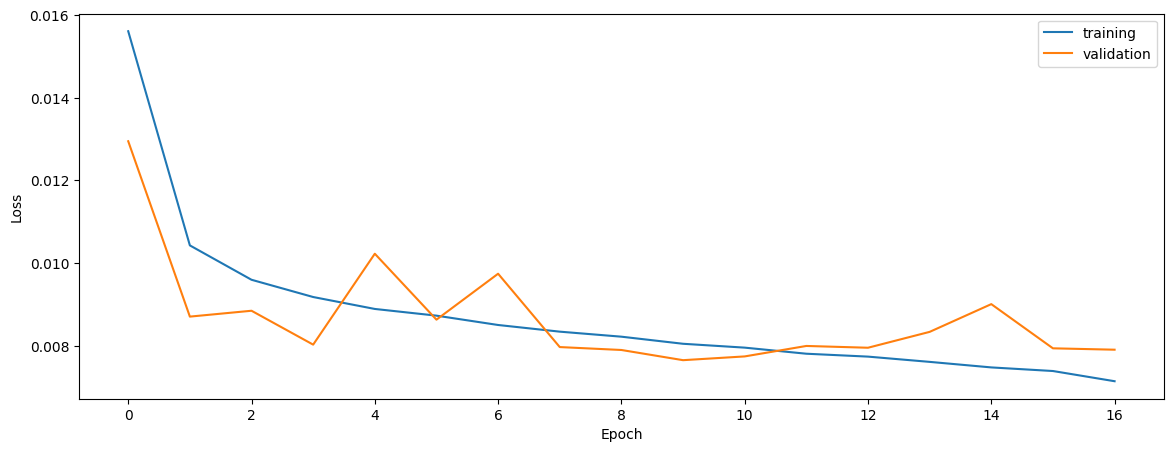

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8494427431804941
0.8344406791343661
0.8338296255447933


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.7478446346989513
0.7305877775426746
0.7345668892413262


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.7534164274475665
0.732723627695137
0.7469795655460609


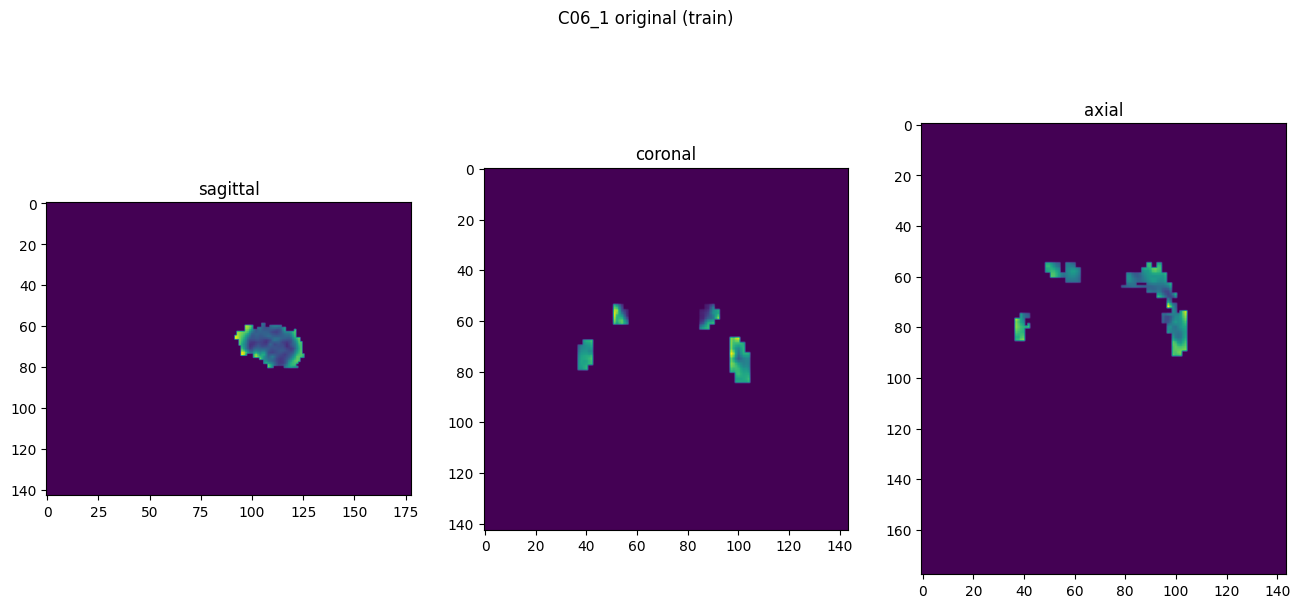

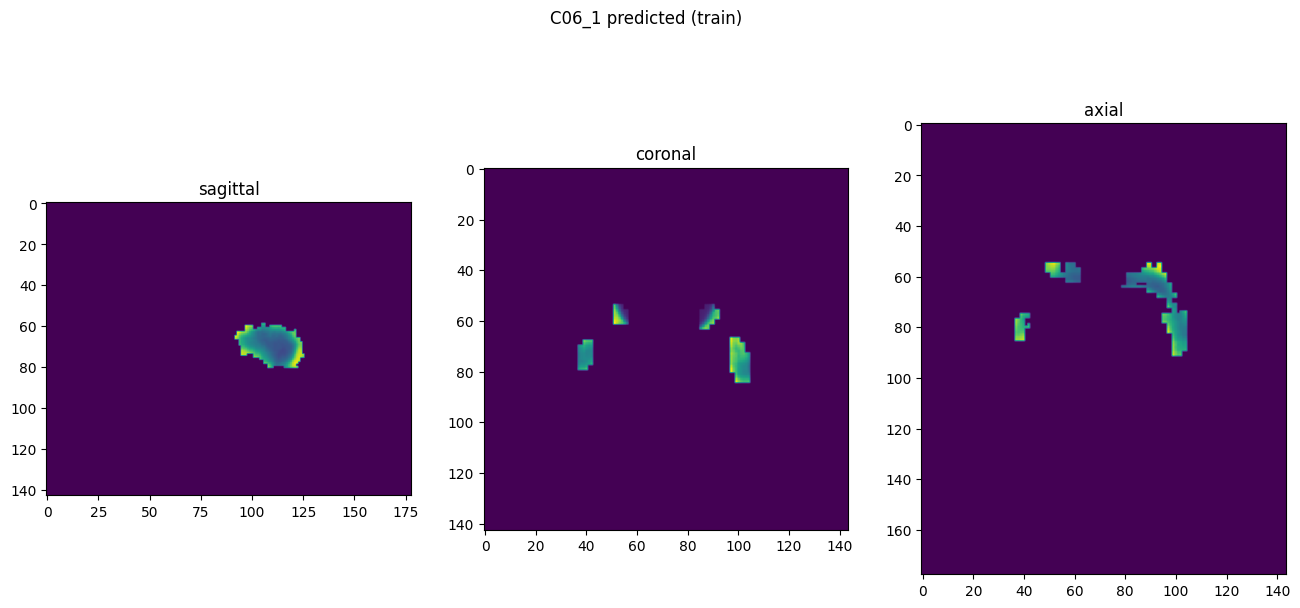

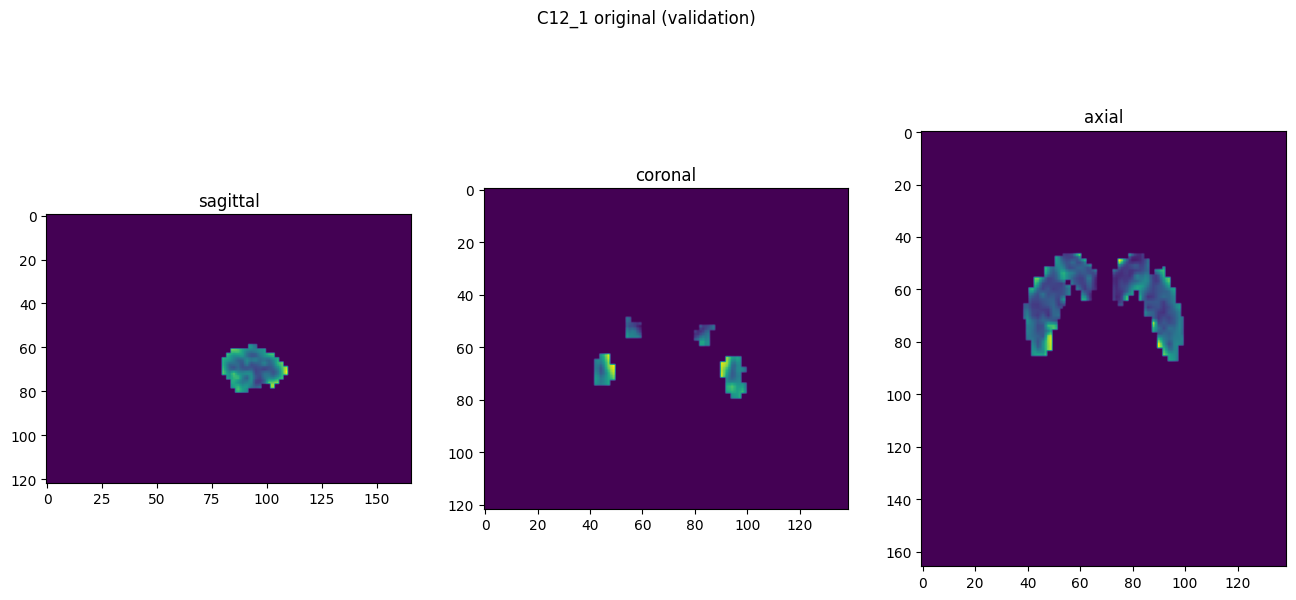

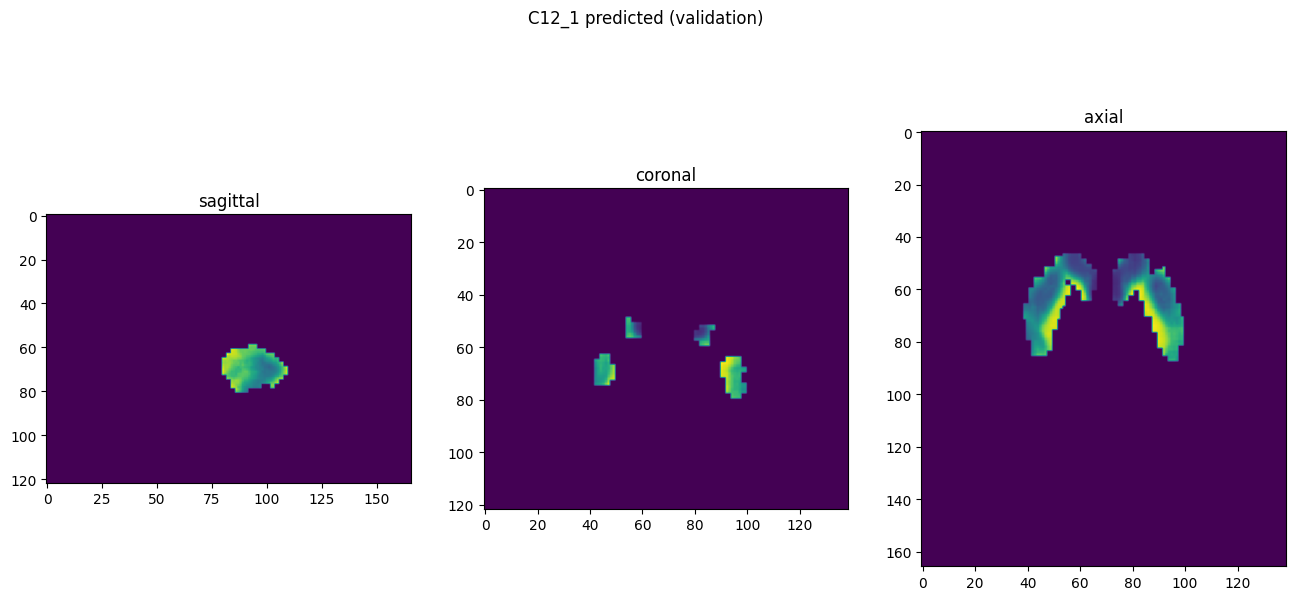

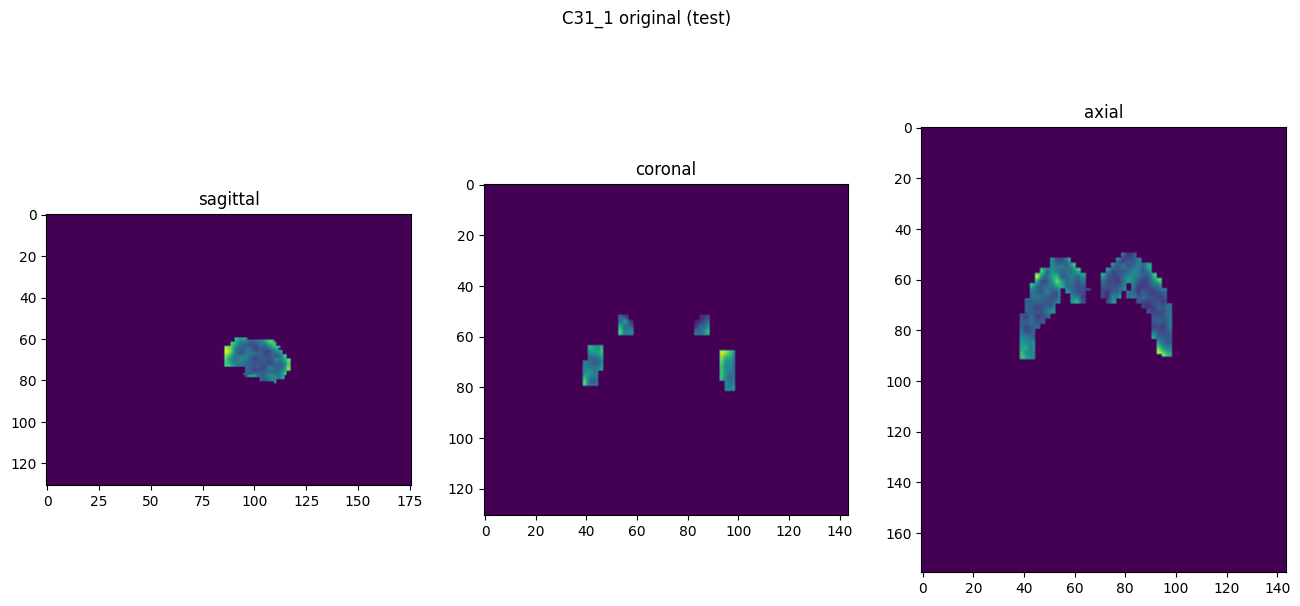

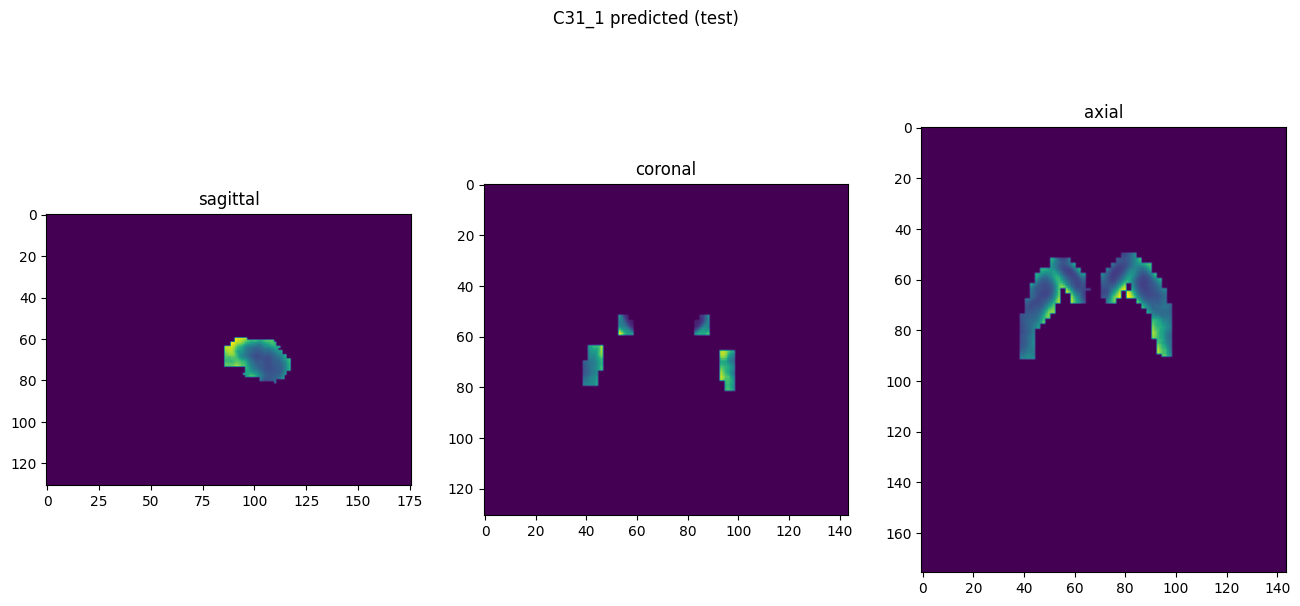

In [10]:
showResults(model, gen, threshold=None, background=False)